### Deep Learning

I den här labben så kommer vi att lära upp en AI att kunna se skillnaden på katter och hundar med och utan augmenterad data, vi kommer att se en skillnad på vår small data och tiny eftersom den har bla mindre att lära sig och jämföra med i tiny jämfört med tiny. 

---

b) Läs in 10 bilder slumpmässigt, plotta dem och extrahera deras labels och skriv ut i titeln.

God uppvärmning som ger oss både övning i att plotta, skriva ut och välja slumpmässiga bilder.



In [24]:
# OBS lägger mina libraries här för att slippa skriva dem varje gång jag ska köra en ny fil.
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import random
import shutil
from PIL import Image
import cv2
import seaborn as sns
from matplotlib.image import imread
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical





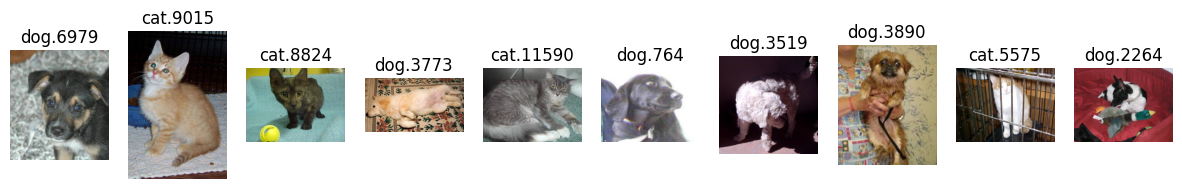

In [6]:
# Sökväg till träningsdata
current_path = Path().absolute()
train_path = current_path / "original_data" / "train"

# Lägg all träningsdata i en lista
train_list = list(train_path.iterdir())

# Sampla 10 bilder random från träninglista
num_images_to_sample = min(10, len(train_list))
if num_images_to_sample > 0:
    # Slumpmässigt välj ut bilder att visa
    pictures = random.sample(train_list, num_images_to_sample)

    # Extrahera labels från filnamn
    labels = [path.stem.split('_')[0] for path in pictures]

    # Plotta bilderna
    fig, axes = plt.subplots(1, num_images_to_sample, figsize=(15, 3))
    if num_images_to_sample > 1:
        axes = axes.flatten()
    else:
        axes = [axes]

    # Loopa genom varje bild och visa dom
    for ax, img_path, label in zip(axes, pictures, labels):
        image = plt.imread(img_path)
        ax.imshow(image)
        ax.set_title(label)
        ax.axis("off")

    plt.show()

---

 c) Skapa folderstrukturen med Pytho.

 Återigen rolig uppvärmning med just python kod, fick hålla tungan rätt i munnen så att allting stämde (OBS ansåg det bättre med att inte ha test/test och train/train på original datan), bord kommenterad så att vi inte kör om den varjegång vi gör en "run all"

In [3]:
"""

# Definiera de olika sökvägarna
experiment_small_data = Path("experiment_small_data")
experiment_tiny_data = Path("experiment_tiny_data")
original_data = Path("original_data")


# Skapa mappstrukturen
experiment_small_data.mkdir(parents=True, exist_ok=True)
experiment_tiny_data.mkdir(parents=True, exist_ok=True)
(original_data / "test").mkdir(parents=True, exist_ok=True)
(original_data / "train").mkdir(parents=True, exist_ok=True)

#Skapa undermappar i experiment_small_data och experiment_tiny_data
for folder in ["test", "train", "val"]:
    (experiment_small_data / folder).mkdir(exist_ok=True)
    (experiment_tiny_data / folder).mkdir(exist_ok=True)

# bugtest så vi vet om något går fel
for item in Path(".").rglob("*"):
     print(item) 

"""

'\n\n# Definiera de olika sökvägarna\nexperiment_small_data = Path("experiment_small_data")\nexperiment_tiny_data = Path("experiment_tiny_data")\noriginal_data = Path("original_data")\n\n\n# Skapa mappstrukturen\nexperiment_small_data.mkdir(parents=True, exist_ok=True)\nexperiment_tiny_data.mkdir(parents=True, exist_ok=True)\n(original_data / "test").mkdir(parents=True, exist_ok=True)\n(original_data / "train").mkdir(parents=True, exist_ok=True)\n\n#Skapa undermappar i experiment_small_data och experiment_tiny_data\nfor folder in ["test", "train", "val"]:\n    (experiment_small_data / folder).mkdir(exist_ok=True)\n    (experiment_tiny_data / folder).mkdir(exist_ok=True)\n\n# bugtest så vi vet om något går fel\nfor item in Path(".").rglob("*"):\n     print(item) \n\n'

---

d) Nu ska du göra train|val|test split med följande splits:

experiment_small
* train - 1600 (800 dogs, 800 cats)
* val - 400 (200 dogs, 200 cats)
* test - 500 (250 dogs, 250 cats)

experiment_tiny (BONUS)
* train - 160 (80 dogs, 80 cats)
* val - 40 (20 dogs, 20 cats)
* test - 50 (25 dogs, 25 cats

Rolig uppgift som fick mig att tänka lite, utmaningen för mig var att lägga en "stop" om vi redan har tillräckligt många bilder i varje folder.

Blandning av olika forum och lite hjälp av GPT för rätt namngivning.

In [25]:
# Sökvägen
current_path = Path().absolute()
original_data = current_path / "original_data" / "train"
experiment_small_data = current_path / "experiment_small_data"
experiment_tiny_data = current_path / "experiment_tiny_data"

# Vad vår split ska vara för varje folder
splits_info = {
    "experiment_small": {"train": 1600, "val": 400, "test": 500},
    "experiment_tiny": {"train": 160, "val": 40, "test": 50}
}

# Funktion för att ställa in dataset för experiment
def setup_datasets(experiment_path, splits, source_data):
    # Skapa experimentfolder om den inte redan finns
    experiment_path.mkdir(parents=True, exist_ok=True)

    # Lista och blanda bilderna random från vår data
    images = list(source_data.glob("*.jpg"))
    random.shuffle(images)  

    # Hantera varje split (train, val, test) enligt tidigare split information
    for split_name, total_images in splits.items():
        split_path = experiment_path / split_name
        split_path.mkdir(parents=True, exist_ok=True)

        # Kolla hur många bilder som redan finns i splitfoldern
        existing_images = list(split_path.glob("*.jpg"))
        num_existing = len(existing_images)
        num_needed = total_images - num_existing

        if num_needed > 0:
            # Om fler bilder behövs, flytta bilder från ursprungsdatan till splitkatalogen
            images_to_move = images[:num_needed]
            images = images[num_needed:]  

            for image in images_to_move:
                shutil.move(str(image), str(split_path / image.name))
            print(f"Flyttade {len(images_to_move)} bilder till {split_path}. Totalt nu: {num_existing + len(images_to_move)}")
        else:
            print(f"{split_name.capitalize()} split i {experiment_path.name} har redan {num_existing} bilder, inga fler behövs.")

# Ställ in dataset för både small och tiny experiment
setup_datasets(experiment_small_data, splits_info["experiment_small"], original_data)
setup_datasets(experiment_tiny_data, splits_info["experiment_tiny"], original_data)


Train split i experiment_small_data har redan 1600 bilder, inga fler behövs.
Val split i experiment_small_data har redan 400 bilder, inga fler behövs.
Test split i experiment_small_data har redan 500 bilder, inga fler behövs.
Train split i experiment_tiny_data har redan 160 bilder, inga fler behövs.
Val split i experiment_tiny_data har redan 40 bilder, inga fler behövs.
Test split i experiment_tiny_data har redan 50 bilder, inga fler behövs.


---

 e) Läs in dataseten från experiment_small, experiment_tiny (BONUS) och plocka ut labelsvektorer, som
ska vara one-hot encoded med 0 och 1.
* plotta några bilder med deras respektive labels och kontrollera att det är korrekt.
* skapa lämplig plot för att kontrollera att dataseten är balanserade
* skapa lämplig plot för att kontrollera att dataseten är slumpade

Lärde mig mycket från denna uppgift att kunna skriva längre kod med repetition från att skriva både small och tiny med utskrift, GPT hjälp med namngivning för att jag inte har någon fantasi.
Bra repetition att använda plots från tidigare labbar.
Som vi kan se i plotten är dom inte exakt uppdelade men lägger ingen större vikt i att få en 50/50, en lösning hade varit att ta bort alla bilder och låta programmet köra igen men är nöjd över resultatet så låter det vara som det är.

Print smalldatat:
y_train: (1600, 2)
y_test: (500, 2)
y_val: (400, 2)

Print tinydata:
y_train: (160, 2)
y_test: (50, 2)
y_val: (40, 2)
Pictures smalldata:


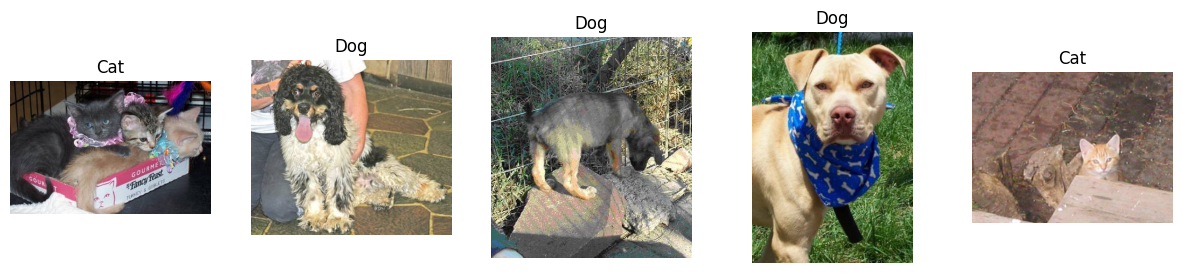

Pictures tinydata:


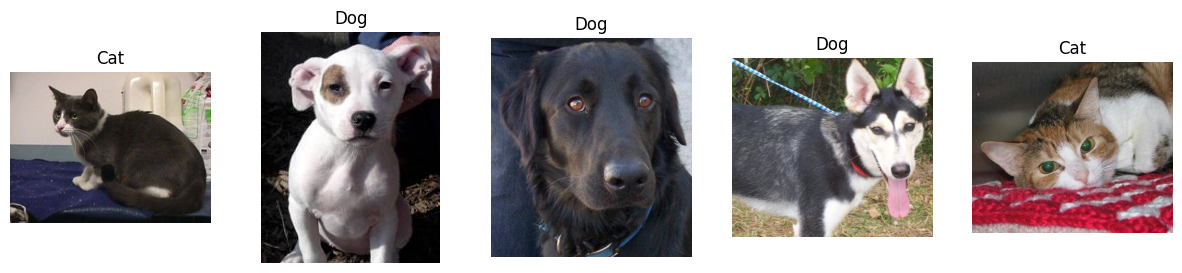

Smalldata:


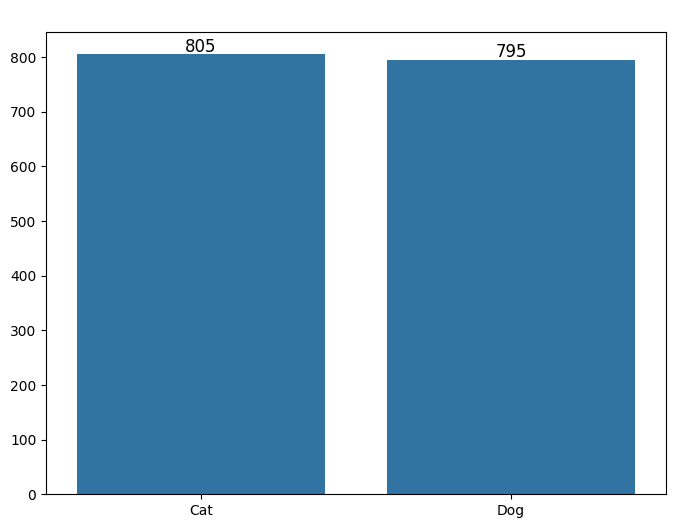

Tinydata:


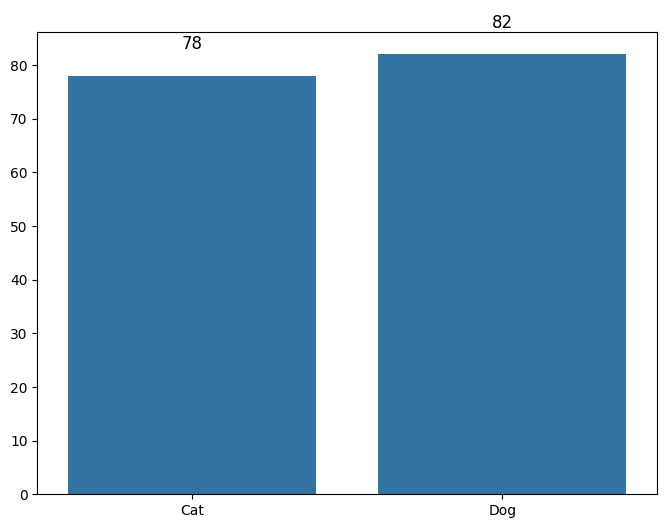

In [26]:

small_train = current_path / experiment_small_data / "train"
small_test = current_path / experiment_small_data / "test"
small_val = current_path / experiment_small_data / "val"
train_list = list(small_train.iterdir())    # Lista med sökvägar till small
test_list = list(small_test.iterdir())  
val_list = list(small_val.iterdir())  

tiny_train = current_path / experiment_tiny_data / "train"
tiny_test = current_path / experiment_tiny_data / "test"
tiny_val = current_path / experiment_tiny_data / "val"
train_list_tiny = list(tiny_train.iterdir())   
test_list_tiny = list(tiny_test.iterdir())  
val_list_tiny = list(tiny_val.iterdir())  

# Sätter etiketter på listorna med 1 för hund och 0 för katt
def label_data(data):
    """"""
    labels = []
    images = []
    np.random.shuffle(data)   # Blanda för att se random bilder
    for path in data:    # Sätter etiketter 1 för hund, 0 för katt
        label = 1 if "dog" in path.name else 0
        labels.append(label)

        image = cv2.imread(str(path))
        images.append(image)

    return images, np.array(labels)

small_data = Path("experiment_small_data") 
tiny_data = Path("experiment_tiny_data") 

# Ladda data
X_train_small, y_train_small = label_data(train_list)
X_test_small, y_test_small = label_data(test_list)
X_val_small, y_val_small = label_data(val_list)

X_train_tiny, y_train_tiny = label_data(train_list_tiny)
X_test_tiny, y_test_tiny = label_data(test_list_tiny)
X_val_tiny, y_val_tiny = label_data(val_list_tiny)

# Onehot encoda etiketterna(to_categorical är GPT lösning)
y_train_small = to_categorical(y_train_small)
y_test_small = to_categorical(y_test_small)
y_val_small = to_categorical(y_val_small)

y_train_tiny = to_categorical(y_train_tiny)
y_test_tiny = to_categorical(y_test_tiny)
y_val_tiny = to_categorical(y_val_tiny)

# Skriv ut vårt dataset
print("Print smalldatat:")
print("y_train:", y_train_small.shape)
#print("X_train:", X_train_small) skriver ut för mycket data men har kvar för att se att det fungerar
print("y_test:", y_test_small.shape)
#print("X_test:", X_test_small)
print("y_val:", y_val_small.shape)
#print("X_val:", X_val_small)

print("\nPrint tinydata:")
print("y_train:", y_train_tiny.shape)
#print("X_train:", X_train_tiny)
print("y_test:", y_test_tiny.shape)
#print("X_test:", X_test_tiny)
print("y_val:", y_val_tiny.shape)
#print("X_val:", X_val_tiny)

# Plottar för att se att allting är korret
def plot_sample_images(images, labels, num_images=5):
    plt.figure(figsize=(15, 3))
    for i in range(num_images):
        ax = plt.subplot(1, num_images, i+1)
        plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)) #GPT lösning
        plt.title("Dog" if np.argmax(labels[i]) == 1 else "Cat")
        plt.axis("off")
    plt.show()

print("Pictures smalldata:")
plot_sample_images(X_train_small, y_train_small)

print("Pictures tinydata:")
plot_sample_images(X_train_tiny, y_train_tiny)

# Plottar för att se att allting är balanserat korret
def plot_label_distribution(labels, title=" "):
    """Plottar delningen av etiketter i datasetet"""
    sns.countplot(np.argmax(labels, axis=1))
    plt.xticks([0, 1], ["Cat", "Dog"])
    plt.show()


# Kontrollerar att datasetet är slumpmässigt
def plot_label_distribution(labels, title=" "):
    # Räkna antalet av varje etikett
    label_counts = np.bincount(np.argmax(labels, axis=1))
    
    plt.figure(figsize=(8, 6))
    sns.barplot(x=["Cat", "Dog"], y=label_counts)
    
    # Lägg till siffrorna ovanför varje bar
    for i, count in enumerate(label_counts):
        plt.text(i, count + 5, str(count), ha='center', fontsize=12)
    
    plt.title(title)
    plt.show()

print("Smalldata:")
plot_label_distribution(y_train_small)

print("Tinydata:")
plot_label_distribution(y_train_tiny)



---
# 1. Bildbehandling (*)
Uppgifterna nedan ska upprepas för respektive experimentdataset om du också väljer att arbeta med
tinydatasetet.

 a) Skapa en plot för att visualisera bildstorlekarna i träningsdatan. Använd seaborns jointplot.

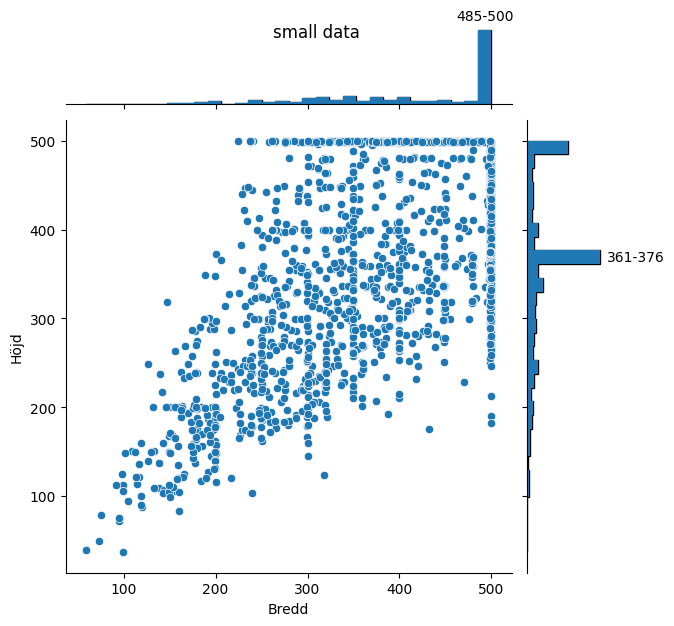

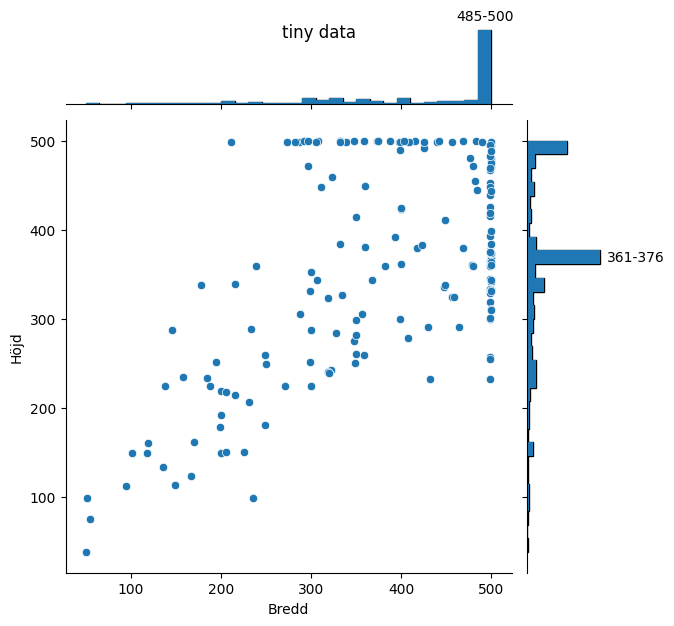

In [28]:
def get_image_sizes(data_path):
    sizes = []
    kategorier = ['train', 'val', 'test']
    for kategori in kategorier:
        kategori_katalog = data_path / kategori
        filer = list(kategori_katalog.glob("*"))
        for bild_sökväg in filer:
            img = imread(str(bild_sökväg))
            if len(img.shape) == 3:
                höjd, bredd, _ = img.shape
                sizes.append((bredd, höjd))
    return sizes

def plot_image_sizes(sizes, title):
    bredd, höjd = zip(*sizes)
    bredd = np.array(bredd)
    höjd = np.array(höjd)

    # Skapa jointplot
    joint_plot = sns.jointplot(x=bredd, y=höjd, kind='scatter', marginal_kws=dict(bins=30, fill=True))
    plt.xlabel('Bredd')
    plt.ylabel('Höjd')
    plt.suptitle(title)

    # Skriv ut den högsta stapeln i x
    n, bins, patches = joint_plot.ax_marg_x.hist(bredd, bins=30, fill=True)
    max_idx = np.argmax(n)
    max_bin_start = bins[max_idx]
    max_bin_end = bins[max_idx + 1]
    joint_plot.ax_marg_x.annotate(f'{int(max_bin_start)}-{int(max_bin_end)}', xy=((max_bin_start + max_bin_end) / 2, max(n)), xytext=(0, 5), textcoords='offset points', ha='center', va='bottom')

    # Skriv ut den högsta stapeln i y
    n, bins, patches = joint_plot.ax_marg_y.hist(höjd, bins=30, fill=True, orientation='horizontal')
    max_idx = np.argmax(n)
    max_bin_start = bins[max_idx]
    max_bin_end = bins[max_idx + 1]
    joint_plot.ax_marg_y.annotate(f'{int(max_bin_start)}-{int(max_bin_end)}', xy=(max(n), (max_bin_start + max_bin_end) / 2), xytext=(5, 0), textcoords='offset points', ha='left', va='center')

    plt.show()

experiment_small_data = Path("experiment_small_data")
experiment_tiny_data = Path("experiment_tiny_data")

# Hämta storlekar från varje set
image_sizes_small = get_image_sizes(experiment_small_data)
image_sizes_tiny = get_image_sizes(experiment_tiny_data)


plot_image_sizes(image_sizes_small, "small data ")
plot_image_sizes(image_sizes_tiny, "tiny data")


---
 b) Välj en lämplig bildstorlek att ändra samtliga bilder till. Gör en analys och fundera på om du behöver
slänga bilder. Hur kommer du fram till ditt val?

Jag fann först infon om att 240x240 är det mest optimala från olika forum, jag försökte med detta först och fick inte bra data från detta, efter en god diskussion med min lärare så testade jag 200x200 och fick mycket bättre data, slutsatsen är att 240x240 blir lite för stor för vårt ändamål och 200x200 är bättre både ifrån hur mycket data(pixlar i detta fall) som vår model behöver tugga igenom och 200x200 inte blir för lite för att den inte kan "se" vad varje bild innehåler.

---
c) Gör resize sådant att samtliga bilder är samma storlek och spara dem i numpy arrays med följande
struktur:
(samples, row, cols, color_channels) 


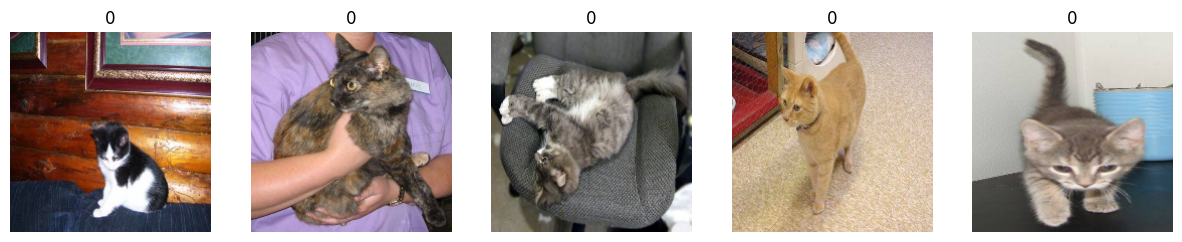

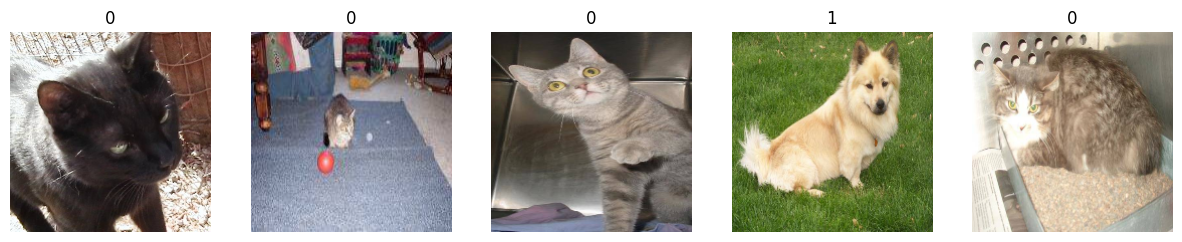

Formerna på små dataset:
X_train_small: (1600, 200, 200, 3)
y_train_small: (1600,)
X_test_small: (500, 200, 200, 3)
y_test_small: (500,)
X_val_small: (400, 200, 200, 3)
y_val_small: (400,)

Formerna på mycket små dataset:
X_train_tiny: (160, 200, 200, 3)
y_train_tiny: (160,)
X_test_tiny: (50, 200, 200, 3)
y_test_tiny: (50,)
X_val_tiny: (40, 200, 200, 3)
y_val_tiny: (40,)


In [32]:
# Definiera sökvägar
current_path = Path('.')  # Sätt den aktuella sökvägen
small_data = current_path / "experiment_small_data"  # Sökväg till små dataset
tiny_data = current_path / "experiment_tiny_data"  # Sökväg till mycket små dataset

# Definiera underkataloger för träning, testning och validering
small_train = small_data / "train"
small_test = small_data / "test"
small_val = small_data / "val"

tiny_train = tiny_data / "train"
tiny_test = tiny_data / "test"
tiny_val = tiny_data / "val"

# Hämta listor över bildsökvägar
train_list = list(small_train.iterdir())  # Lista över träningsbilder för små dataset
test_list = list(small_test.iterdir())  # Lista över testbilder för små dataset
val_list = list(small_val.iterdir())  # Lista över valideringsbilder för små dataset
train_list_tiny = list(tiny_train.iterdir())  # Lista över träningsbilder för mycket små dataset
test_list_tiny = list(tiny_test.iterdir())  # Lista över testbilder för mycket små dataset
val_list_tiny = list(tiny_val.iterdir())  # Lista över valideringsbilder för mycket små dataset

def label_and_resize_data(data, image_size=(200, 200)):
    """
    Etiketterar listorna med 1 för hund och 0 för katt, ändrar storlek på bilderna till given storlek och returnerar numpy-arrayer.
    """
    labels = []  # Lista för etiketter
    images = []  # Lista för bilder
    np.random.shuffle(data)  # Blanda datan slumpmässigt
    for path in data:
        label = 1 if "dog" in path.name else 0  # Sätt etikett baserat på filnamnet
        labels.append(label)

        image = cv2.imread(str(path))  # Läs bilden med OpenCV
        if image is not None:
            image = cv2.resize(image, image_size)  # Ändra storlek på bilden
            images.append(image)

    return np.array(images), np.array(labels)  # Returnera bilder och etiketter som numpy-arrayer

# Ladda, etikettera och ändra storlek på datan
X_train_small, y_train_small = label_and_resize_data(train_list)
X_test_small, y_test_small = label_and_resize_data(test_list)
X_val_small, y_val_small = label_and_resize_data(val_list)

X_train_tiny, y_train_tiny = label_and_resize_data(train_list_tiny)
X_test_tiny, y_test_tiny = label_and_resize_data(test_list_tiny)
X_val_tiny, y_val_tiny = label_and_resize_data(val_list_tiny)

# Normalisera datan
X_train_small = X_train_small / 255.0  # Normalisera träningsbilder för små dataset
X_test_small = X_test_small / 255.0  # Normalisera testbilder för små dataset
X_val_small = X_val_small / 255.0  # Normalisera valideringsbilder för små dataset

X_train_tiny = X_train_tiny / 255.0  # Normalisera träningsbilder för mycket små dataset
X_test_tiny = X_test_tiny / 255.0  # Normalisera testbilder för mycket små dataset
X_val_tiny = X_val_tiny / 255.0  # Normalisera valideringsbilder för mycket små dataset

def display_random_images(images, labels, num_images=5):
    """
    Visa några slumpmässiga bilder med deras etiketter.
    """
    indices = np.random.choice(np.arange(len(images)), num_images, replace=False)  # Välj slumpmässiga index
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))  # Skapa en rad av underfigurer
    for i, ax in zip(indices, axes):
        img = (images[i] * 255).astype(np.uint8)  # Konvertera tillbaka till uint8 för visning
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Konvertera färg från BGR till RGB
        ax.set_title(f'{labels[i]}')  # Sätt titel som visar etiketten
        ax.axis('off')  # Dölj axlar
    plt.show()  # Visa figuren

# Visa några slumpmässiga träningsbilder från små dataset
display_random_images(X_train_small, y_train_small)
display_random_images(X_train_tiny, y_train_tiny)

# Skriv ut formerna på datasets
print("Formerna på små dataset:")
print("X_train_small:", X_train_small.shape)
print("y_train_small:", y_train_small.shape)
print("X_test_small:", X_test_small.shape)
print("y_test_small:", y_test_small.shape)
print("X_val_small:", X_val_small.shape)
print("y_val_small:", y_val_small.shape)

print("\nFormerna på mycket små dataset:")
print("X_train_tiny:", X_train_tiny.shape)
print("y_train_tiny:", y_train_tiny.shape)
print("X_test_tiny:", X_test_tiny.shape)
print("y_test_tiny:", y_test_tiny.shape)
print("X_val_tiny:", X_val_tiny.shape)
print("y_val_tiny:", y_val_tiny.shape)


---






In [8]:


def create_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dropout(0.3),
        Dense(512, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


c:\Users\lager\Desktop\Github\AI-Bjorn-Lagerblad-OPA23\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 349ms/step - accuracy: 0.5056 - loss: 1.1446 - val_accuracy: 0.5175 - val_loss: 0.6912
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.5170 - loss: 0.6908 - val_accuracy: 0.6000 - val_loss: 0.6607
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 388ms/step - accuracy: 0.6107 - loss: 0.6530 - val_accuracy: 0.6350 - val_loss: 0.6370
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 391ms/step - accuracy: 0.6504 - loss: 0.6235 - val_accuracy: 0.6325 - val_loss: 0.6538
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 399ms/step - accuracy: 0.7417 - loss: 0.5288 - val_accuracy: 0.6850 - val_loss: 0.5931
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 410ms/step - accuracy: 0.7935 - loss: 0.4692 - val_accuracy: 0.6800 - val_loss: 0.6438
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 23s 452ms/step - accuracy: 0.8337 - loss: 0.3987 - val_accuracy: 0.6625 - val_loss: 0.7024
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 423ms/step - accuracy: 0.8557 - loss: 0.3466 - val_accu

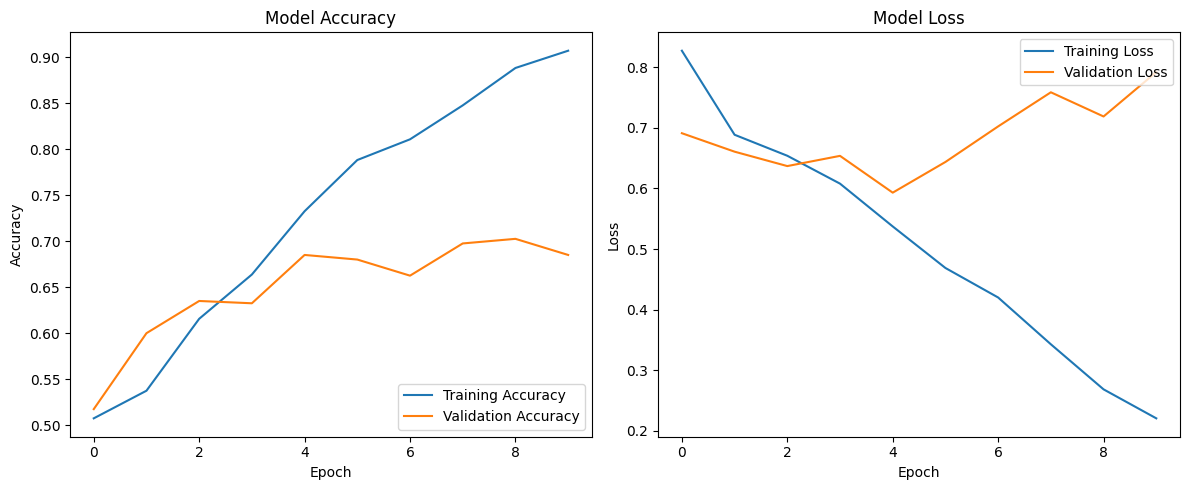

In [9]:


model_small = create_model()

history_small = model_small.fit(X_train_small, y_train_small, batch_size=32, epochs=10, 
                                validation_data=(X_val_small, y_val_small))

plt.figure(figsize=(12, 5))  

plt.subplot(1, 2, 1)  
plt.plot(history_small.history['accuracy'], label='Training Accuracy')
plt.plot(history_small.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2) 
plt.plot(history_small.history['loss'], label='Training Loss')
plt.plot(history_small.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout() 
plt.show()


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 433ms/step - accuracy: 0.4938 - loss: 1.7578 - val_accuracy: 0.5000 - val_loss: 0.6939
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 379ms/step - accuracy: 0.5020 - loss: 0.6889 - val_accuracy: 0.5000 - val_loss: 0.7056
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 367ms/step - accuracy: 0.5696 - loss: 0.6628 - val_accuracy: 0.5250 - val_loss: 0.6963
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 364ms/step - accuracy: 0.5700 - loss: 0.6700 - val_accuracy: 0.6000 - val_loss: 0.6510
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.6827 - loss: 0.5908 - val_accuracy: 0.5500 - val_loss: 0.8353
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 371ms/step - accuracy: 0.7299 - loss: 0.5414 - val_accuracy: 0.5000 - val_loss: 0.6587
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 373ms/step - accuracy: 0.8285 - loss: 0.4604 - val_accuracy: 0.5250 - val_loss: 0.8025
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 363ms/step - accuracy: 0.8404 - loss: 0.3651 - val_accuracy: 0.5000 - val_loss:

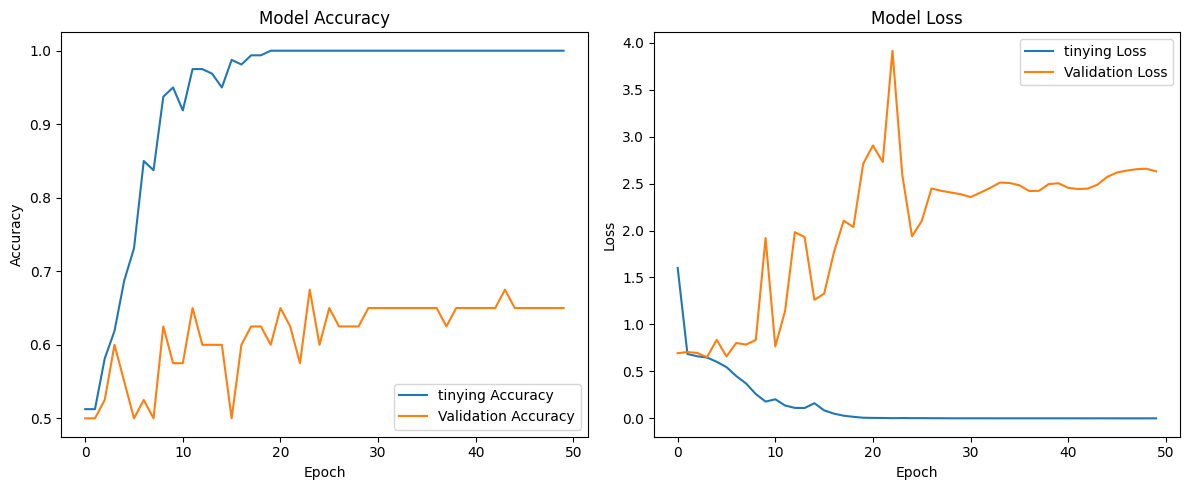

In [19]:
model_tiny = create_model()

history_tiny = model_tiny.fit(X_train_tiny, y_train_tiny, batch_size=32, epochs=50, 
                                validation_data=(X_val_tiny, y_val_tiny))

plt.figure(figsize=(12, 5))  

plt.subplot(1, 2, 1)  
plt.plot(history_tiny.history['accuracy'], label='tinying Accuracy')
plt.plot(history_tiny.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2) 
plt.plot(history_tiny.history['loss'], label='tinying Loss')
plt.plot(history_tiny.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout() 
plt.show()

#test


---
---
 d) Augmentera datan. Varför behövs dataaugmentering och hur beslutar du vilka parametrar du valt för
augmenteringen

Exempel på parametrar för bilddataaugmentering kan inkludera:

    Rotation: Bilden roteras med ett slumpmässigt vinkel.
    Skalning: Bildstorleken ändras genom zoomning in och ut.
    Horisontell/Vertikal spegling: Bilden speglas horisontellt eller vertikalt.
    Färgjustering: Ändringar i ljusstyrka, kontrast, mättnad, och nyans.

Shapes of Augmented Small Data:
X_train_small: (1600, 200, 200, 3)
y_train_small: (1600,)


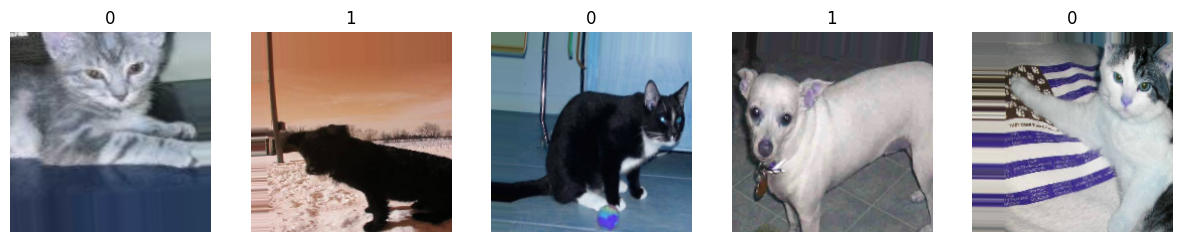

Shapes of Augmented Tiny Data:
X_train_tiny: (160, 200, 200, 3)
y_train_tiny: (160,)


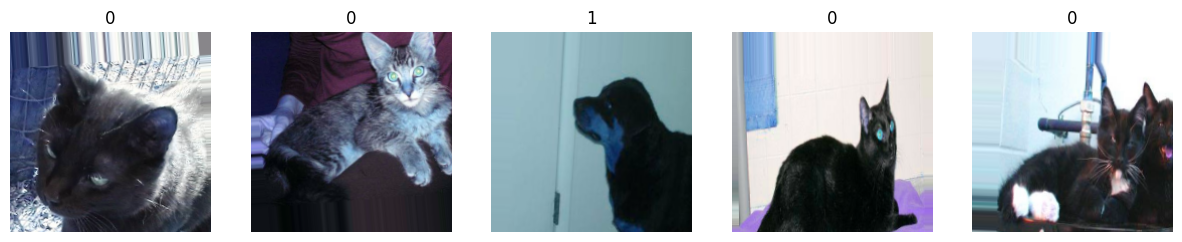

In [1]:


# Paths
base_path = Path('.')
small_data = base_path / "experiment_small_data"
tiny_data = base_path / "experiment_tiny_data"

# Data Generator with additional augmentations
data_gen = ImageDataGenerator(
    rotation_range=5, 
    shear_range=0.1,    
    zoom_range=0.1,     
    horizontal_flip=True,
    height_shift_range=0.2, 
    width_shift_range=0.2,
)

def load_and_augment_images(data_path, image_size=(200, 200)):
    images = []
    labels = []
    for img_path in data_path.iterdir():
        label = 1 if 'dog' in img_path.name else 0
        image = cv2.imread(str(img_path))
        if image is not None:
            image = cv2.resize(image, image_size)
            image = np.expand_dims(image, axis=0)
            image = next(data_gen.flow(image, batch_size=1))[0]  # Augment image
            images.append(image)
            labels.append(label)
    return np.array(images), np.array(labels)

# Load and augment the data
X_train_small, y_train_small = load_and_augment_images(small_data / 'train')
X_train_tiny, y_train_tiny = load_and_augment_images(tiny_data / 'train')

# Normalize the data after augmentation
X_train_small = X_train_small / 255.0
X_train_tiny = X_train_tiny / 255.0

# Display augmented images
def display_augmented_images(images, labels, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for i, ax in zip(range(num_images), axes):
        idx = np.random.randint(0, len(images))
        ax.imshow(images[idx])
        ax.set_title(f'{labels[idx]}')
        ax.axis('off')
    plt.show()

# Display some augmented images
print("Shapes of Augmented Small Data:")
print("X_train_small:", X_train_small.shape)
print("y_train_small:", y_train_small.shape)
display_augmented_images(X_train_small, y_train_small)

print("Shapes of Augmented Tiny Data:")
print("X_train_tiny:", X_train_tiny.shape)
print("y_train_tiny:", y_train_tiny.shape)
display_augmented_images(X_train_tiny, y_train_tiny)

----

augmenterad data

Epoch 1/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 35s 659ms/step - accuracy: 0.5719 - loss: 8.2253 - val_accuracy: 0.4875 - val_loss: 2.4780
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 40s 795ms/step - accuracy: 0.5806 - loss: 0.9246 - val_accuracy: 0.4975 - val_loss: 11.4581
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 40s 794ms/step - accuracy: 0.6041 - loss: 0.6648 - val_accuracy: 0.5075 - val_loss: 5.5859
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 37s 746ms/step - accuracy: 0.7078 - loss: 0.5557 - val_accuracy: 0.4900 - val_loss: 13.9446
Epoch 5/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 34s 684ms/step - accuracy: 0.7747 - loss: 0.4677 - val_accuracy: 0.5175 - val_loss: 7.0397
Epoch 6/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 34s 670ms/step - accuracy: 0.8258 - loss: 0.3821 - val_accuracy: 0.5050 - val_loss: 9.3883
Epoch 7/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 34s 679ms/step - accuracy: 0.8933 - loss: 0.2832 - val_accuracy: 0.5300 - val_loss: 5.7000
Epoch 8/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 34s 675ms/step - accuracy: 0.9407 - loss: 0.1669 - val_ac

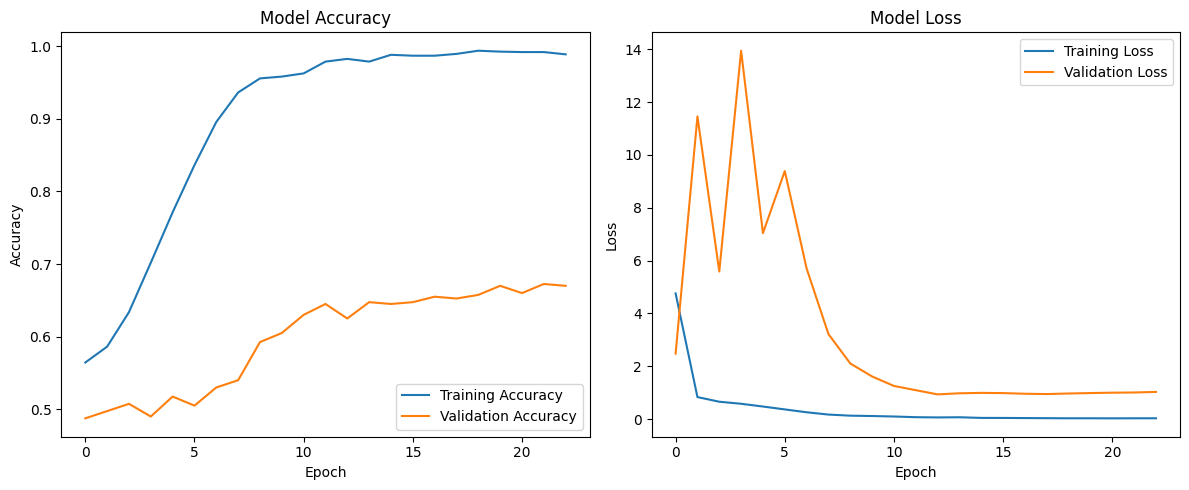

In [14]:


# Validation data augmentation (without random transformations)
data_gen_val = ImageDataGenerator(rescale=1./255)

small_data_val = small_data / 'val'
X_val_small, y_val_small = load_and_augment_images(small_data_val, image_size=(200, 200))
X_val_small = X_val_small / 255.0

# Model definition with BatchNormalization
def create_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, 3)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dropout(0.3),
        Dense(512, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Custom callback to remove learning rate from logs
class CustomReduceLROnPlateau(ReduceLROnPlateau):
    def on_epoch_end(self, epoch, logs=None):
        super().on_epoch_end(epoch, logs)
        if 'learning_rate' in logs:
            logs.pop('learning_rate')

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = CustomReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

model_small = create_model()

history_small = model_small.fit(
    X_train_small, y_train_small,
    batch_size=32,
    epochs=30,
    validation_data=(X_val_small, y_val_small),
    callbacks=[early_stopping, reduce_lr]
)

# Plotting the results
plt.figure(figsize=(12, 5))  
plt.subplot(1, 2, 1)  
plt.plot(history_small.history['accuracy'], label='Training Accuracy')
plt.plot(history_small.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2) 
plt.plot(history_small.history['loss'], label='Training Loss')
plt.plot(history_small.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout() 
plt.show()


tiny data

Epoch 1/30


c:\Users\lager\Desktop\Github\AI-Bjorn-Lagerblad-OPA23\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 742ms/step - accuracy: 0.5705 - loss: 12.1744 - val_accuracy: 0.4750 - val_loss: 0.8028
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 674ms/step - accuracy: 0.7777 - loss: 4.5669 - val_accuracy: 0.5000 - val_loss: 1.6561
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 721ms/step - accuracy: 0.8660 - loss: 1.4969 - val_accuracy: 0.5000 - val_loss: 4.2958
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 652ms/step - accuracy: 0.9061 - loss: 1.2310 - val_accuracy: 0.5000 - val_loss: 7.2082
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 712ms/step - accuracy: 0.9450 - loss: 1.0623 - val_accuracy: 0.5000 - val_loss: 9.6261
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 656ms/step - accuracy: 0.9680 - loss: 0.1539 - val_accuracy: 0.5000 - val_loss: 8.4073
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 658ms/step - accuracy: 0.9765 - loss: 0.1288 - val_accuracy: 0.5000 - val_loss: 7.8291
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 671ms/step - accuracy: 0.9795 - loss: 0.0872 - val_accuracy: 0.4500 - val_loss: 7.3647
Ep

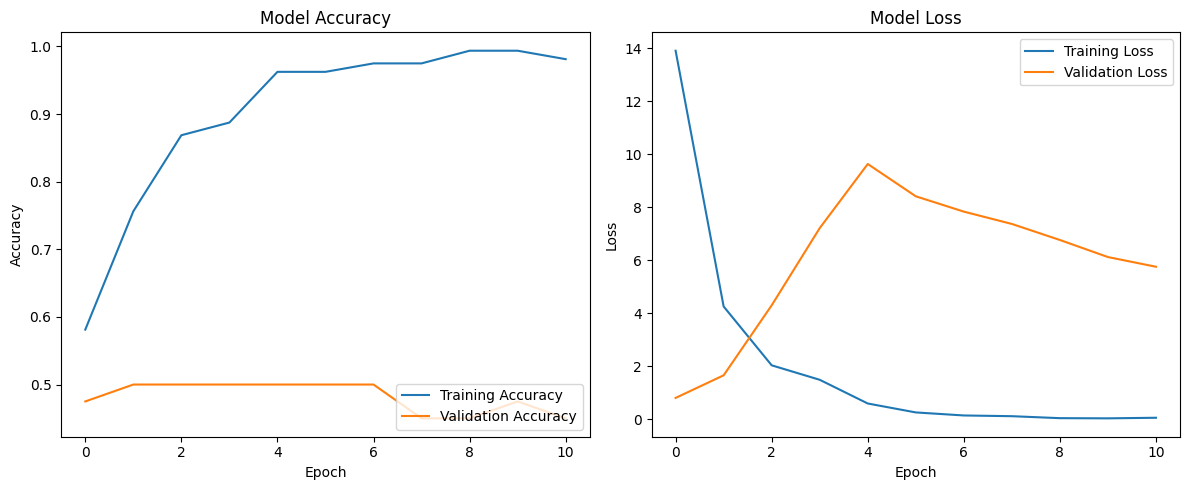

In [20]:


# Validation data augmentation (without random transformations)
data_gen_val = ImageDataGenerator(rescale=1./255)

tiny_data_val = tiny_data / 'val'
X_val_tiny, y_val_tiny = load_and_augment_images(tiny_data_val, image_size=(200, 200))
X_val_tiny = X_val_tiny / 255.0

# Model definition with BatchNormalization
def create_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, 3)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dropout(0.3),
        Dense(512, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Custom callback to remove learning rate from logs
class CustomReduceLROnPlateau(ReduceLROnPlateau):
    def on_epoch_end(self, epoch, logs=None):
        super().on_epoch_end(epoch, logs)
        if 'learning_rate' in logs:
            logs.pop('learning_rate')

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = CustomReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

model_tiny = create_model()

history_tiny = model_tiny.fit(
    X_train_tiny, y_train_tiny,
    batch_size=32,
    epochs=30,
    validation_data=(X_val_tiny, y_val_tiny),
    callbacks=[early_stopping, reduce_lr]
)

# Plotting the results
plt.figure(figsize=(12, 5))  
plt.subplot(1, 2, 1)  
plt.plot(history_tiny.history['accuracy'], label='Training Accuracy')
plt.plot(history_tiny.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2) 
plt.plot(history_tiny.history['loss'], label='Training Loss')
plt.plot(history_tiny.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout() 
plt.show()


---
transfer learning